In [6]:
%load_ext autoreload
%autoreload 2
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import matplotlib.pyplot as plt
from pathlib import Path

sys.path.append("../utility_packages/")
from image_utils import label_images, plot_images, count_samples

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import Model, Sequential, models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
np.random.seed(6)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# # verify if tensorflow is running with GPU
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

# # check if keras is using GPU
print(K.tensorflow_backend._get_available_gpus())

## Define data, sample size, and image parameters

In [19]:
# define datasets
train_data_dir = "../../data/seg_train/"
test_data_dir = "../../data/seg_test/"
pred_data_dir = "../../data/seg_pred/"
 
# define datasets and sample size
num_train_samples = count_samples(train_data_dir)
num_test_samples = count_samples(test_data_dir)
num_pred_samples = count_samples(pred_data_dir, y_values = False)

# define image dimensions
img_width, img_height = 150, 150
img_target_size = (img_width, img_height)

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

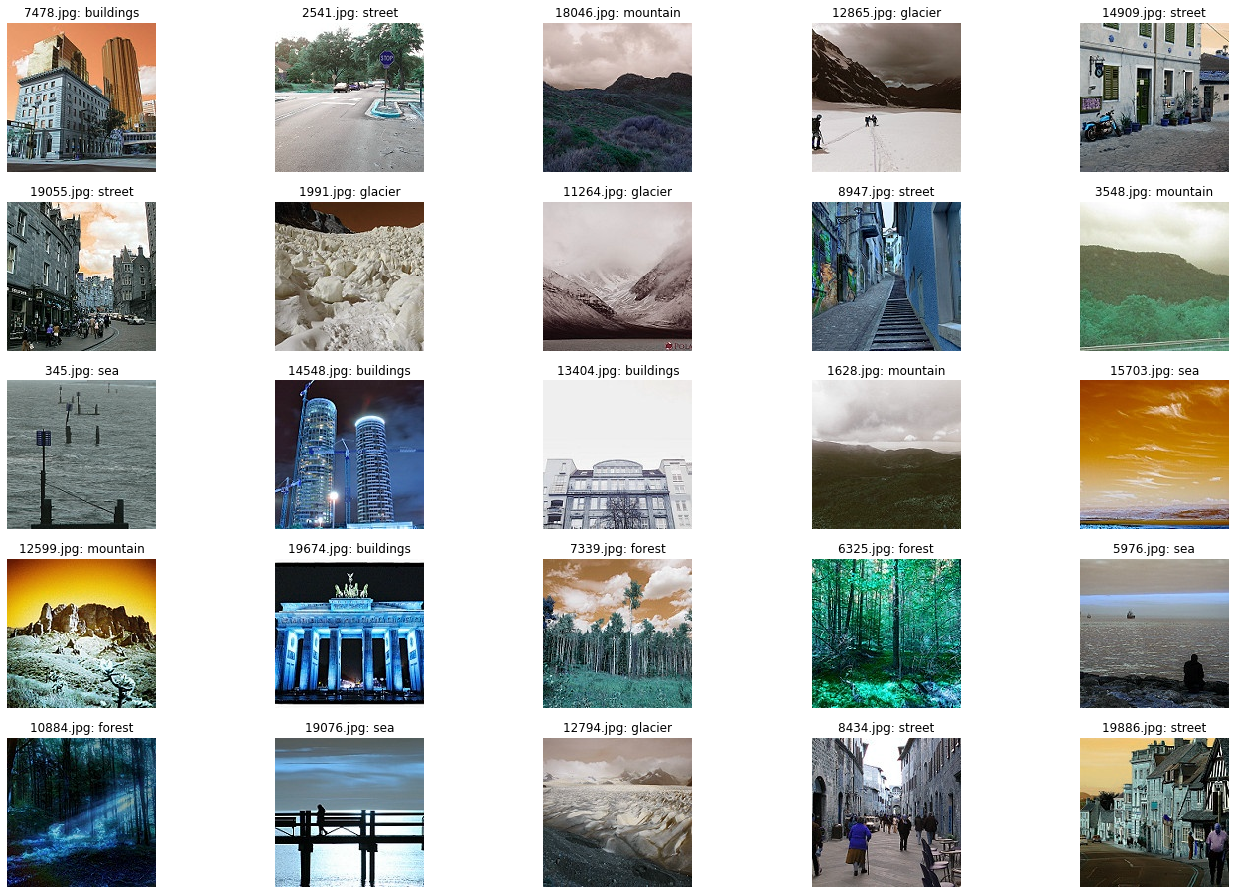

In [21]:
training_imgs, training_img_labels = label_images(train_data_dir, '.jpg')
plot_images(training_imgs, training_img_labels)

## Define hyperparameters and data generators

In [115]:
# define model hyperparameters
epochs = 10
batch_size = 64
neurons_per_layer = [2048, 1024, 512]
dropout = 0.5
n_classes = 6
patience = 3

# specify image augmentation
img_augmentation = ImageDataGenerator(preprocessing_function=preprocess_input,
      rotation_range=90,
      horizontal_flip=True,
      vertical_flip=True)

# prepare train/test data generators
train_data = img_augmentation.flow_from_directory(
    train_data_dir,
    target_size = img_target_size,
    batch_size = batch_size,
    class_mode = 'categorical')

test_data = img_augmentation.flow_from_directory(
    test_data_dir,
    target_size = img_target_size,
    batch_size = batch_size,
    class_mode = 'categorical')

pred_data = img_augmentation.flow_from_directory(
    pred_data_dir,
    target_size = img_target_size,
    batch_size = batch_size,
    class_mode = None,
    shuffle = False)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Found 7301 images belonging to 1 classes.


## Get Label Map

In [127]:
# Make label map
label_map = {v: k for k, v in train_data.class_indices.items()}

## Create and train model

In [23]:
# specify base model and freeze weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# create model function
def create_model(base_model, dropout, neurons_per_layer, num_classes):
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = layers.Flatten()(x)
    
    for num_neurons in neurons_per_layer:
        x = layers.Dense(num_neurons, activation='relu')(x) 
    
    x = layers.Dropout(dropout)(x)

    classifications = layers.Dense(num_classes, activation='softmax')(x) 
    model = Model(inputs=base_model.input, outputs=classifications)
    
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['acc'])

    return model

# instantiate model
model = create_model(base_model, dropout=dropout, neurons_per_layer=neurons_per_layer, num_classes=n_classes)

/Users/ebolotin/Dropbox/techdev/env/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
callbacks = [EarlyStopping(monitor='val_acc', patience=patience),
             ModelCheckpoint(filepath='resnet_iic_kaggle.h5', monitor='val_acc', save_best_only=True)]

# train model
history = model.fit_generator(
    train_data,
    steps_per_epoch = num_train_samples // batch_size,
    validation_data = test_data,
    validation_steps = num_test_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    verbose = 1,
    use_multiprocessing = True)

## Load model

In [25]:
model.load_weights('resnet_iic_kaggle.h5')

## Plot training vs val accuracy

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Perform CV

In [ ]:
test_score = model.evaluate_generator(test_data,
    steps = num_test_samples // batch_size,
    verbose=1,
    use_multiprocessing=True)

print("Test loss {:.4f}, accuracy {:.2f}%".format(test_score[0], test_score[1] * 100))

## Make predictions

In [76]:
pred_imgs, pred_img_labels = label_images(pred_data_dir, '.jpg')

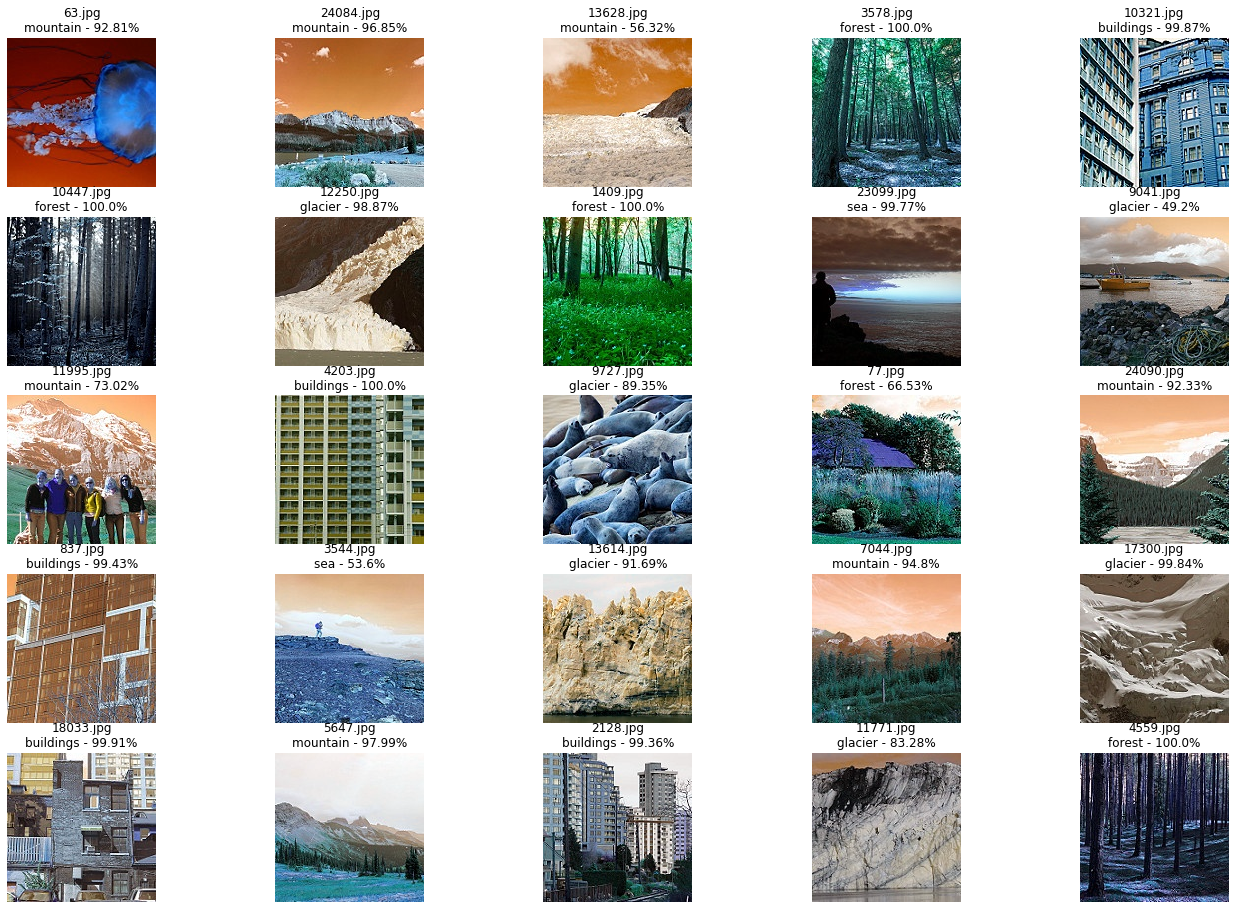

In [137]:
def plot_predictions(pred_data_dir, seed = 3):
    f,ax = plt.subplots(5,5) 
    f.subplots_adjust(0,0,3,3)
    np.random.seed(seed)
    
    for root, dirs, files in os.walk(pred_data_dir):
        if not dirs:
            num_files = len(files)
            indices = np.random.choice(num_files, 25, replace=False)

    idx = 0
    for i in range(0,5):
        for j in range(0,5):
            pred_img = np.array([pred_imgs[idx]])
            predictions = model.predict(pred_img).ravel()
            max_prob = str(round(predictions.max()*100,2))
            max_class = label_map[predictions.argmax()]
            image_name = str(pred_img_labels[idx][0])

            ax[i,j].imshow(pred_imgs[idx])
            ax[i,j].set_title(f"{image_name}\n{max_class} - {max_prob}%")
            ax[i,j].axis('off')
            idx += 1

plot_predictions(pred_data_dir)

In [ ]:
pred_score = model.predict_generator(pred_data,
    steps = num_pred_samples // batch_size,
    verbose=1,
    use_multiprocessing=True)

print(pred_score)